In [1]:
suppressMessages(library(fable))
suppressMessages(library(forecast))
suppressMessages(library(tidyverse))
suppressMessages(library(tsibble))
suppressMessages(library(scales))
suppressMessages(library(feasts))
suppressMessages(library(magrittr))
suppressMessages(library(tsibble))
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
suppressMessages(library(lubridate))
suppressMessages(library(gridExtra))
suppressMessages(library(tidyr))

In [2]:
data <- read.csv('monthly_housing_inventory.csv')

In [3]:
data |> head()

,month_date_yyyymm,county_name,median_listing_price,active_listing_count,new_listing_count,pending_listing_count,median_listing_price_per_square_foot,median_square_feet,average_listing_price,total_listing_count
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,202403,"hartley, tx",425000,12,0,1,289,3024,444336,12
2,202403,"rock, mn",309900,21,8,13,136,2016,397205,35
3,202403,"carter, ok",199000,165,56,59,127,1633,306719,222
4,202403,"mckean, pa",169000,48,12,25,89,1898,187270,71
5,202403,"etowah, al",248950,236,128,67,124,1894,296370,303
6,202403,"dawson, ga",679450,135,76,80,227,2802,814852,211


# Finding Min and Max

In [16]:
max <- max(data$average_listing_price, na.rm = TRUE)
min <- min(data$average_listing_price, na.rm = TRUE)
print('min')
print(min)
print('max')
print(max)

[1] "min"
[1] 5000
[1] "max"
[1] 142882807


# Missing Values 

In [5]:
# Count the number of null values in each column
null_counts <- sapply(data, function(x) sum(is.na(x)))
print(null_counts)
print(sum(null_counts))

                   month_date_yyyymm                          county_name 
                                   0                                    0 
                median_listing_price                 active_listing_count 
                                  63                                   45 
                   new_listing_count                pending_listing_count 
                                  43                                23871 
median_listing_price_per_square_foot                   median_square_feet 
                                 328                                  325 
               average_listing_price                  total_listing_count 
                                  63                                   43 
[1] 24781


In [17]:
# Identifying breaks in the time series (assuming monthly data)

data$month_date_yyyymm <- as.Date(data$month_date_yyyymm)

time_diff <- diff(data$month_date_yyyymm)
break_indices <- which(time_diff > months(1))

break_indices

integer(0)

In [7]:
data |> head()

,month_date_yyyymm,county_name,median_listing_price,active_listing_count,new_listing_count,pending_listing_count,median_listing_price_per_square_foot,median_square_feet,average_listing_price,total_listing_count
,<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2524-02-29,"hartley, tx",425000,12,0,1,289,3024,444336,12
2,2524-02-29,"rock, mn",309900,21,8,13,136,2016,397205,35
3,2524-02-29,"carter, ok",199000,165,56,59,127,1633,306719,222
4,2524-02-29,"mckean, pa",169000,48,12,25,89,1898,187270,71
5,2524-02-29,"etowah, al",248950,236,128,67,124,1894,296370,303
6,2524-02-29,"dawson, ga",679450,135,76,80,227,2802,814852,211


# Correlation between the metrics

In [8]:

df <- read.csv('monthly_housing_inventory.csv')
National <- df %>%
mutate(feet = median_square_feet * total_listing_count,price = average_listing_price * total_listing_count) %>%
group_by(month_date_yyyymm) %>%
summarise(
    total_listings = sum(total_listing_count, na.rm = TRUE),
    price = sum(price,na.rm = TRUE),
    feet = sum(feet, na.rm=TRUE),
    new_listings = sum(new_listing_count,na.rm = TRUE),
    total_active_listings = sum(active_listing_count,na.rm = TRUE), .groups='drop',
) %>%
mutate(Median_square_feet = feet / total_listings, Average_listing_price = price / total_listings) %>%
mutate(month_date = tsibble::yearmonth(as.character(month_date_yyyymm), '%Y%m')) %>%

as_tsibble(index=month_date)

In [9]:
tidy <- National |> select()

In [10]:
National |> head()

month_date_yyyymm,total_listings,price,feet,new_listings,total_active_listings,Median_square_feet,Average_listing_price,month_date
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<mth>
201607,1873362,850645942280,3716755730,497388,1463458,1984.003,454074.5,2016 Jul
201608,1845212,830236012455,3643898579,464934,1456819,1974.786,449940.7,2016 Aug
201609,1809143,814639852826,3564169188,444898,1443501,1970.087,450290.5,2016 Sep
201610,1753435,797982155209,3444454981,410322,1404257,1964.404,455096.5,2016 Oct
201611,1664952,761648287880,3258029271,352640,1337018,1956.831,457459.6,2016 Nov
201612,1522590,698562982208,2955454646,266860,1232380,1941.071,458799.1,2016 Dec


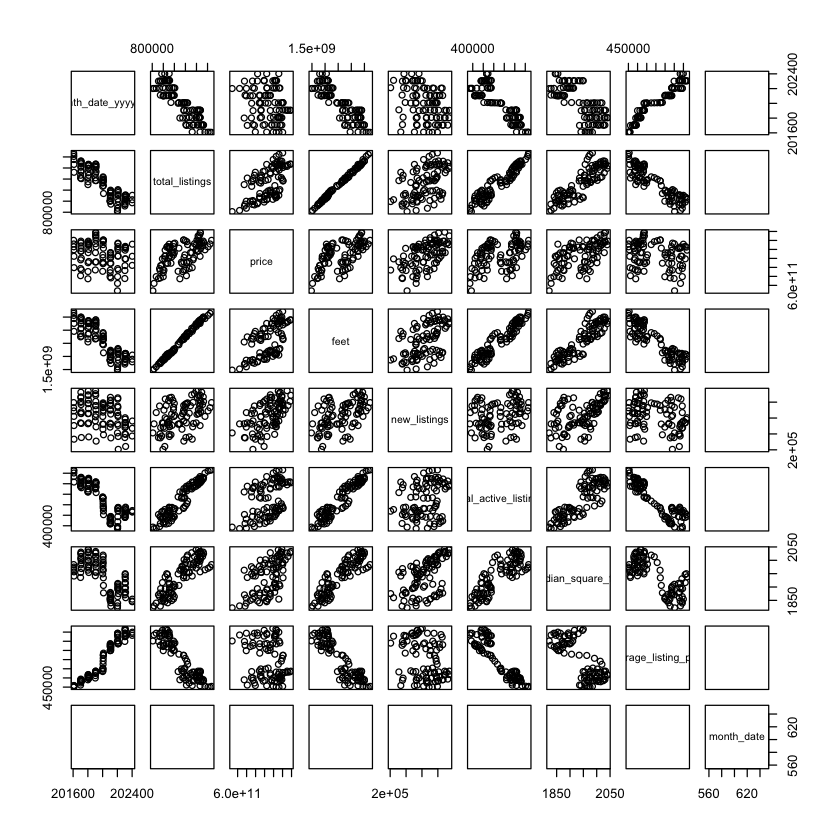

In [19]:
National |> pairs()

# I have considered the below metrics that show strong correlations

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


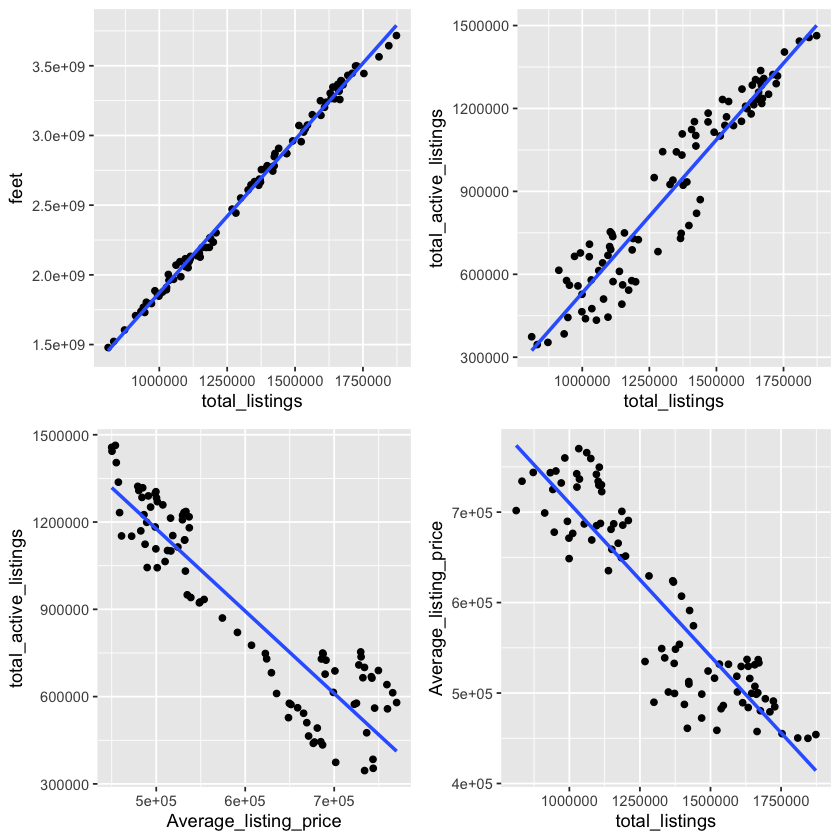

In [18]:
plot1 <- National |>
  ggplot(aes(x = total_listings, y = feet)) +
  geom_point() +
  geom_smooth(method = "lm", se = FALSE)

plot2 <- National |>
  ggplot(aes(x = total_listings, y = total_active_listings)) +
  geom_point() +
  geom_smooth(method = "lm", se = FALSE)

plot3 <- National |>
  ggplot(aes(x = Average_listing_price, y = total_active_listings)) +
  geom_point() +
  geom_smooth(method = "lm", se = FALSE)

plot4 <- National |>
  ggplot(aes(x = total_listings, y = Average_listing_price)) +
  geom_point() +
  geom_smooth(method = "lm", se = FALSE)

# Arrange plots in a grid
grid.arrange(plot1, plot2, plot3, plot4, ncol = 2)

We can observe Increasing Correlation for total listings to feet and total active Listings. And Decreasing correlation for total active listing and average listing price and average listing price to total listings which I have used for modelling.